In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vehicle-detection-and-classification/[Train]Images-for-feature-extration_features/label_encoder.joblib
/kaggle/input/vehicle-detection-and-classification/[Train]Images-for-feature-extration_features/scaler.joblib
/kaggle/input/vehicle-detection-and-classification/[Train]Images-for-feature-extration_features/y.npy
/kaggle/input/vehicle-detection-and-classification/[Train]Images-for-feature-extration_features/X.npy
/kaggle/input/vehicle-detection-and-classification/[TEST]Images-for-feature-extraction_features/label_encoder.joblib
/kaggle/input/vehicle-detection-and-classification/[TEST]Images-for-feature-extraction_features/scaler.joblib
/kaggle/input/vehicle-detection-and-classification/[TEST]Images-for-feature-extraction_features/y.npy
/kaggle/input/vehicle-detection-and-classification/[TEST]Images-for-feature-extraction_features/X.npy


In [2]:
# --- Core Libraries ---
import numpy as np
import joblib
import os

# --- Scikit-learn for Modeling ---
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# --- Scikit-learn for Evaluation ---
from sklearn.metrics import accuracy_score, classification_report



In [3]:
BASE_PATH = '/kaggle/input/vehicle-detection-and-classification/'

TRAIN_DATA_PATH = os.path.join(BASE_PATH, '[Train]Images-for-feature-extration_features')
TEST_DATA_PATH = os.path.join(BASE_PATH, '[TEST]Images-for-feature-extraction_features') 

# --- Load Training Data ---
X_train = np.load(os.path.join(TRAIN_DATA_PATH, 'X.npy'))
y_train = np.load(os.path.join(TRAIN_DATA_PATH, 'y.npy'))
print(f"Training data loaded. Features shape: {X_train.shape}, Labels shape: {y_train.shape}")

# --- Load Testing Data ---
X_test = np.load(os.path.join(TEST_DATA_PATH, 'X.npy'))
y_test = np.load(os.path.join(TEST_DATA_PATH, 'y.npy'))
print(f"Testing data loaded. Features shape: {X_test.shape}, Labels shape: {y_test.shape}")

# --- Load the Label Encoder and Scaler ---
label_encoder = joblib.load(os.path.join(TRAIN_DATA_PATH, 'label_encoder.joblib'))
print("Label encoder loaded.")

Training data loaded. Features shape: (2220, 10165), Labels shape: (2220,)
Testing data loaded. Features shape: (435, 10165), Labels shape: (435,)
Label encoder loaded.


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.6.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
# --- Level 0: Define the Base Models ---
# base_estimators = [
#     ('knn', KNeighborsClassifier(n_neighbors=5)),
#     ('svc', SVC(kernel='rbf', probability=True, C=1.0)), 
#     ('gbm', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1))
# ]
base_estimators = [
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('dt', DecisionTreeClassifier(max_depth=10)),
    ('gbm', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1))
]

# --- Level 1: Define the Meta-Model ---
meta_estimator = LogisticRegression(solver='liblinear')

# --- Create the Stacking Classifier ---

stacking_model = StackingClassifier(
    estimators=base_estimators,
    final_estimator=meta_estimator,
    cv=5,
    verbose=2, 
    n_jobs=-1 
)

print("Stacking Classifier defined successfully!")
print(stacking_model)

Stacking Classifier defined successfully!
StackingClassifier(cv=5,
                   estimators=[('knn', KNeighborsClassifier()),
                               ('dt', DecisionTreeClassifier(max_depth=10)),
                               ('gbm', GradientBoostingClassifier())],
                   final_estimator=LogisticRegression(solver='liblinear'),
                   n_jobs=-1, verbose=2)


In [5]:
# --- Train the model on the training data ---
stacking_model.fit(X_train, y_train)
print("Training complete!")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.6s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


Training complete!


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 66.8min finished


In [6]:
import joblib
import os

# Assuming 'stacking_model' is your variable holding the trained model
# and you have already run:
# y_pred = stacking_model.predict(X_test)

# 1. Define a filename for the saved model
model_filename = 'stack_vehicle_classifier.joblib'

# 2. Use joblib.dump to save the model to a file
joblib.dump(stacking_model, model_filename)

# 3. Print a confirmation message with the full path to the file
print(f"Model saved successfully to: {os.path.abspath(model_filename)}")

Model saved successfully to: /kaggle/working/stack_vehicle_classifier.joblib


In [7]:
# --- Make predictions on the test set ---
print("Making predictions on the test data...")
y_pred = stacking_model.predict(X_test)

# --- Calculate the overall accuracy ---
accuracy = accuracy_score(y_test, y_pred)
print(f"\nOverall Model Accuracy: {accuracy:.4f}")

# --- Generate a detailed classification report ---
class_names = label_encoder.classes_
report = classification_report(y_test, y_pred, target_names=class_names)

print("\nClassification Report:")
print(report)

Making predictions on the test data...


OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec


Overall Model Accuracy: 0.7655

Classification Report:
              precision    recall  f1-score   support

          P1       0.94      0.79      0.86       258
          P2       0.81      0.52      0.64        67
          P3       0.54      0.85      0.66       110

    accuracy                           0.77       435
   macro avg       0.76      0.72      0.72       435
weighted avg       0.82      0.77      0.77       435



OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

Classification Report
              precision    recall  f1-score   support

          P1       0.94      0.79      0.86       258
          P2       0.81      0.52      0.64        67
          P3       0.54      0.85      0.66       110

    accuracy                           0.77       435
   macro avg       0.76      0.72      0.72       435
weighted avg       0.82      0.77      0.77       435


Confusion Matrix


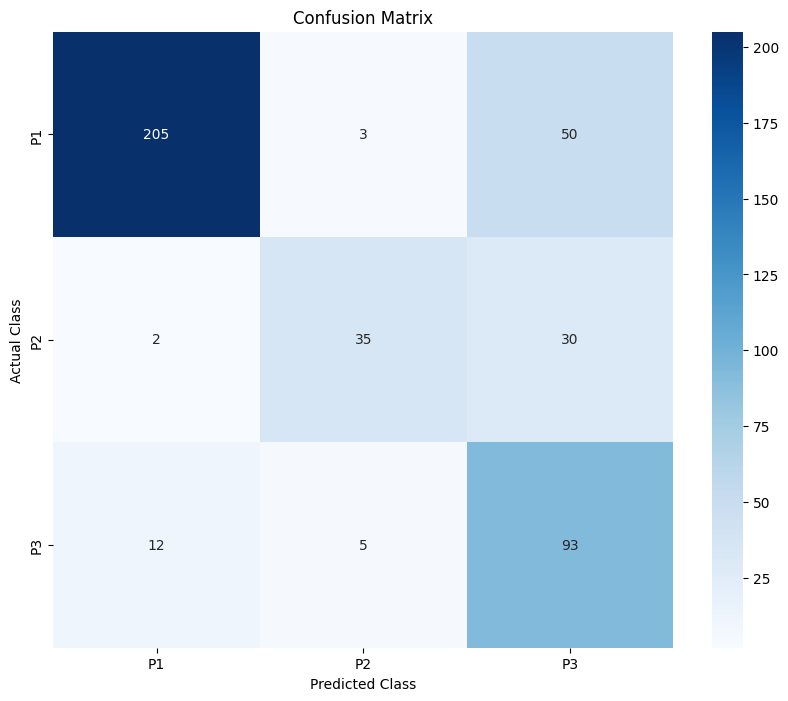


Precision-Recall (PR) Curve


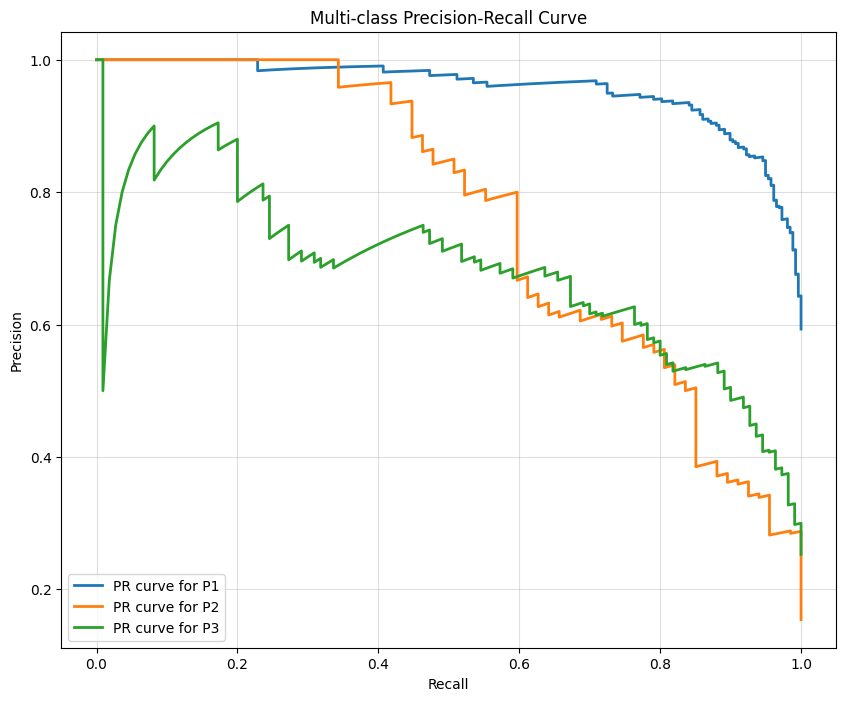


Receiver Operating Characteristic (ROC) Curve


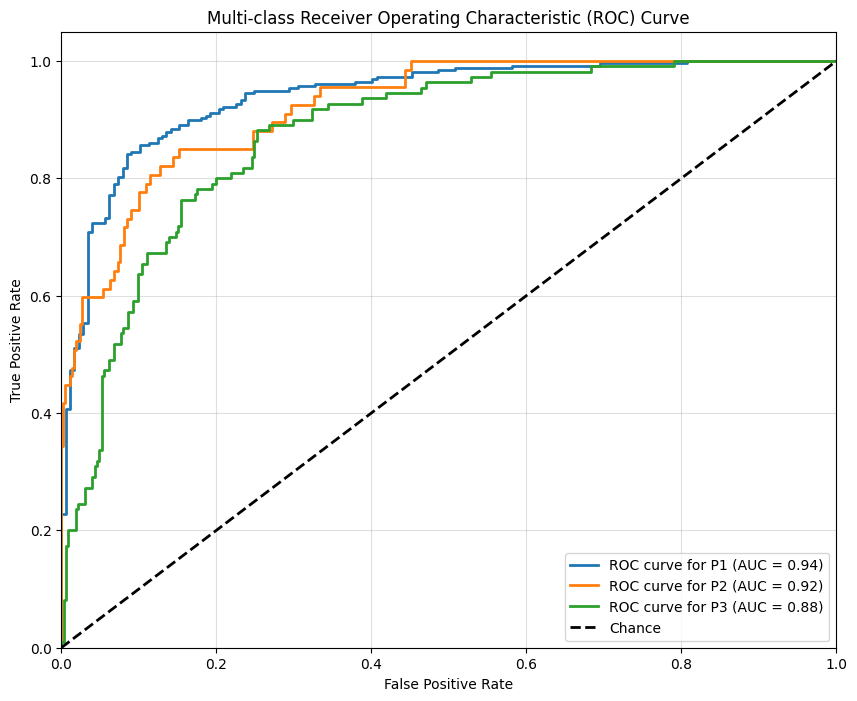

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve
)
from sklearn.preprocessing import LabelBinarizer

# Assuming 'stacking_model', 'X_test', 'y_test', and 'label_encoder'
# are already defined from your previous steps.

# --- 1. GET PREDICTIONS AND PROBABILITY SCORES ---

# Get standard class predictions for the report and confusion matrix
y_pred = stacking_model.predict(X_test)

# Get the probability scores for each class for ROC and PR curves
# This is crucial as these curves work by varying the probability threshold.
y_scores = stacking_model.predict_proba(X_test)


# --- 2. CLASSIFICATION REPORT ---

print("="*50)
print("Classification Report")
print("="*50)
class_names = label_encoder.classes_
print(classification_report(y_test, y_pred, target_names=class_names))


# --- 3. CONFUSION MATRIX ---

print("\n" + "="*50)
print("Confusion Matrix")
print("="*50)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d', # Integer format
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.title('Confusion Matrix')
plt.show()


# --- PREPARE FOR MULTI-CLASS CURVES ---
# We need to binarize the output labels for multi-class evaluation
label_binarizer = LabelBinarizer().fit(y_train)
y_test_binarized = label_binarizer.transform(y_test)
n_classes = len(class_names)


# --- 4. PRECISION-RECALL (PR) CURVE ---

print("\n" + "="*50)
print("Precision-Recall (PR) Curve")
print("="*50)

plt.figure(figsize=(10, 8))
# Plot PR curve for each class
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_scores[:, i])
    plt.plot(recall, precision, lw=2, label=f'PR curve for {class_names[i]}')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Multi-class Precision-Recall Curve")
plt.legend(loc="best")
plt.grid(alpha=0.4)
plt.show()


# --- 5. RECEIVER OPERATING CHARACTERISTIC (ROC) CURVE ---

print("\n" + "="*50)
print("Receiver Operating Characteristic (ROC) Curve")
print("="*50)

plt.figure(figsize=(10, 8))
# Plot ROC curve for each class
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(
        fpr,
        tpr,
        lw=2,
        label=f'ROC curve for {class_names[i]} (AUC = {roc_auc:.2f})'
    )

# Plot the "chance" line (a classifier with no skill)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(alpha=0.4)
plt.show()

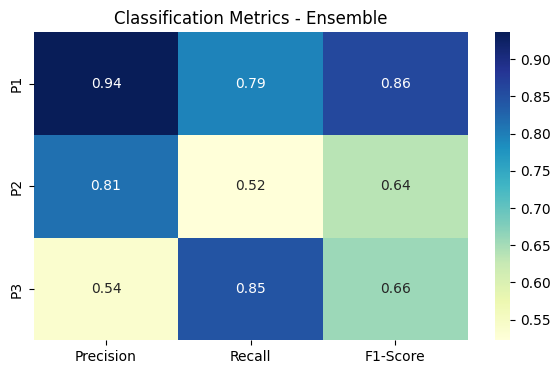

In [9]:
report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
report_df = np.array([[report[label]['precision'], report[label]['recall'], report[label]['f1-score']] for label in class_names])
plt.figure(figsize=(7, 4))
sns.heatmap(report_df, annot=True, fmt=".2f", cmap="YlGnBu", xticklabels=["Precision", "Recall", "F1-Score"], yticklabels=class_names)
plt.title("Classification Metrics - Ensemble")
plt.show()